# 05 Teemaanalüüs

# 1. Andmete eeltöötlus - puhastamine, sõnestamine, lemmatiseerimine, stoppsõnad

In [1]:
from estnltk import Text
import estnltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gensim
from pprint import pprint
from gensim import corpora
import pyLDAvis.gensim
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

In [2]:
df = pd.read_excel('remmelgas/KÕIK TEKSTID_Haabersti_hoberemmelgas.xlsx', engine='openpyxl')
print(df.shape)

(306, 8)


In [3]:
tekst_list = df['text'].to_list()
print(len(tekst_list))

306


In [4]:
tekst_list[12]

'Lõppeva aasta üks tunnusjoon oli meeleavalduste ja protestimise rohkus. Nimetades kõige kaalukamaid: Rail Balticu vastu, Eesti metsade kaitseks, tselluloositehase vastu, aga ka Haabersti ristmikule ette jäänud hõberemmelga kaitseks ja Tallinna Reidi tee vastu. Väiksemal määral kodanikuaktivismi vallandus ka aktsiisipoliitika vastu, linnahalli seinamaalingu säilitamise poolt jne. Miks mitte lisada siia ritta ka Rakvere lihatööstuse töötajate spontaanne streik? Need kodanikuaktivismi ilmingud olid oma ulatuselt ja sisult äärmiselt erinevad. Näiteks Rail Balticu vastu tõusis terve asjatundjate armee. Ka Eesti metsade intensiivse raiumise ja Tartu lähedale Emajõe kaldale kerkida võiva tselluloositehase vastane protest pole jäänud vaid õhinapõhiseks. Seevastu Haabersti hõberemmelga kaitsmise aktsioon võttis nii karikatuurse kuju, et sellest distantseerisid ennast paljud loodusesõbradki – kuigi suures plaanis juhiti ju tähelepanu valulikule teemale, linnalooduse läbimõtlematule hävitamisele

In [5]:
# Funktsioon sümbolite eemaldamiseks
def remove_newlines_tabs(text):
    Formatted_text = text.replace('\n', '').replace('\n\n', '').replace(u'\xa0', '').replace(u'\xad', '').replace(u'\x96', '').replace('_x000d_', '').replace(u'\x9e', '').replace(u'\x93', '').replace(u'\x94', '')
    return Formatted_text

# Funktsioon html-vormingute eemaldamiseks
def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    # Get all the text other than html tags.
    stripped_text = soup.get_text(separator=" ")
    return stripped_text

# Funktsioon liigsete tühikute eemaldamiseks
def remove_whitespace(text):
    pattern = re.compile(r'\s+') 
    without_whitespace = re.sub(pattern, ' ', text)
    return without_whitespace

In [6]:
# Teksti puhastamine
from bs4 import BeautifulSoup
import re
tekst_puhas = []
for tekst in tekst_list:
    s = strip_html_tags(tekst)    
    s = remove_newlines_tabs(s)
    s = remove_whitespace(s)
    tekst_puhas.append(s)

In [7]:
len(tekst_puhas)

306

In [8]:
tekst_puhas[12]

'Lõppeva aasta üks tunnusjoon oli meeleavalduste ja protestimise rohkus. Nimetades kõige kaalukamaid: Rail Balticu vastu, Eesti metsade kaitseks, tselluloositehase vastu, aga ka Haabersti ristmikule ette jäänud hõberemmelga kaitseks ja Tallinna Reidi tee vastu. Väiksemal määral kodanikuaktivismi vallandus ka aktsiisipoliitika vastu, linnahalli seinamaalingu säilitamise poolt jne. Miks mitte lisada siia ritta ka Rakvere lihatööstuse töötajate spontaanne streik? Need kodanikuaktivismi ilmingud olid oma ulatuselt ja sisult äärmiselt erinevad. Näiteks Rail Balticu vastu tõusis terve asjatundjate armee. Ka Eesti metsade intensiivse raiumise ja Tartu lähedale Emajõe kaldale kerkida võiva tselluloositehase vastane protest pole jäänud vaid õhinapõhiseks. Seevastu Haabersti hõberemmelga kaitsmise aktsioon võttis nii karikatuurse kuju, et sellest distantseerisid ennast paljud loodusesõbradki – kuigi suures plaanis juhiti ju tähelepanu valulikule teemale, linnalooduse läbimõtlematule hävitamisele

In [9]:
df['text_puhas'] = tekst_puhas

In [10]:
from estnltk import Text

# Meetodid teksti sõnestamiseks estnltk abil
def tokenize_with_estnltk( input_string ):
    return Text(input_string).tag_layer(['words']).words.text

def lemmatize_with_estnltk(input_string):
    #lemmad = Text(input_string).tag_layer(['morph_analysis']).lemma
    lemmad = Text(input_string).tag_layer().morph_analysis['lemma','partofspeech']
    flattened = []
    for sublist in lemmad:
        if sublist[0][1] == 'S' or sublist[0][1] == 'A' or sublist[0][1] == 'C' or sublist[0][1] == 'U':
            flattened.append(sublist[0][0]) #valib esimese lemma
    return flattened

In [11]:
# Kirjavahemärkide eemaldamine
import string

def punctuation_removal(text):
    result = string.punctuation
    all_list = [char for char in text if char  not in string.punctuation]
    clean_str = ' '.join(all_list)
    return clean_str

In [12]:
# Teksti sõnestamine ja puhastamine kirjavahemärkidest
tekst_tokenize = []

for tekst in tekst_puhas:
    s = tokenize_with_estnltk(tekst.lower())
    s = punctuation_removal(s)
    s = s.strip(".")
    s = s.replace('“', '').replace('„', '').replace('”', '').replace('–', '').replace('...', '').replace('«', '').replace('»', '').replace('…', '')
    tekst_tokenize.append(s)

In [13]:
tekst_tokenize[12]

'lõppeva aasta üks tunnusjoon oli meeleavalduste ja protestimise rohkus nimetades kõige kaalukamaid rail balticu vastu eesti metsade kaitseks tselluloositehase vastu aga ka haabersti ristmikule ette jäänud hõberemmelga kaitseks ja tallinna reidi tee vastu väiksemal määral kodanikuaktivismi vallandus ka aktsiisipoliitika vastu linnahalli seinamaalingu säilitamise poolt jne miks mitte lisada siia ritta ka rakvere lihatööstuse töötajate spontaanne streik need kodanikuaktivismi ilmingud olid oma ulatuselt ja sisult äärmiselt erinevad näiteks rail balticu vastu tõusis terve asjatundjate armee ka eesti metsade intensiivse raiumise ja tartu lähedale emajõe kaldale kerkida võiva tselluloositehase vastane protest pole jäänud vaid õhinapõhiseks seevastu haabersti hõberemmelga kaitsmise aktsioon võttis nii karikatuurse kuju et sellest distantseerisid ennast paljud loodusesõbradki  kuigi suures plaanis juhiti ju tähelepanu valulikule teemale linnalooduse läbimõtlematule hävitamisele väike nihe  kü

In [14]:
# Teksti lemmatiseerimine ja puhastamine kirjavahemärkidest
tekst_lemmatize = []
for tekst in tekst_puhas:
    s = lemmatize_with_estnltk(tekst.lower())
    s = punctuation_removal(s)
    s = s.strip(".")
    s = s.replace('“', '').replace('„', '').replace('”', '').replace('–', '').replace('...', '').replace('«', '').replace('»', '').replace('…', '')
    tekst_lemmatize.append(s)

In [15]:
tekst_lemmatize[12]

'lõppev aasta tunnusjoon meeleavaldus protestimine rohkus kaalukam rai balticu mets kaitse tselluloositehas haaberst ristmik hõberemmelgas kaitse reid tee väiksem määr kodanikuaktivism aktsiisipoliitika linnahall seinamaaling säilitamine rida lihatööstus töötaja spontaanne streik kodanikuaktivism ilming ulatus sisu erinev näide rai balticu terve asjatundja armee mets intensiivne raiumine emajõgi kallas võiv tselluloositehas vastane protest õhinapõhis haaberst hõberemmelgas kaitsmine aktsioon karikatuurne kuju loodusesõber suur plaan tähelepanu valulik teema linnaloodus läbimõtlematu hävitamine väike nihe küsitav oluline paremus reid tee küsimus roheline koostöö saatan protest projekt elu viiv keskerakondlik linnavõim meeleavaldaja asi meel suurem probleem võim rahvas otsus tegemine õige aeg teema asjatundlik oponent argument võimupoliitik ärijuht dialoog oskus täielik võõrandumine revolutsioon'

In [16]:
# Sidesõnad
#stop_words = ['ja', 'ning', 'ega', 'ehk', 'või', 'aga', 'kuid', 'ent', 'vaid', 'et', 'kui', 'kuna', 'sest', 'kuni', 'kuigi', 
#             'ehkki', 'nagu', 'saati', 'elik', 'justkui', 'otsekui', 'seni']

# Sidesõnad ja asesõnad ja veel sõnu
stop_words = ['ja', 'ning', 'ega', 'ehk', 'või', 'aga', 'kuid', 'ent', 'vaid', 'et', 'kui', 'kuna', 'sest', 'kuni', 'kuigi', 
             'ehkki', 'nagu', 'saati', 'elik', 'justkui', 'otsekui', 'seni', 'siis', 'ka', 'nii', 'kas',
             'mina', 'ma', 'meie', 'me', 'sina', 'sa', 'teie', 'te', 'tema', 'ta', 'nemad', 'nad',
             'enese', 'enda', 'iseenese', 'iseenda', 'oma', 'üksteise', 'teineteise',
             'see', 'too', 'sama', 'seesama', 'toosama', 'teine', 'muu',
             'niisugune', 'samasugune', 'niisamasugune', 'selline', 'seesugune', 'säärane','säherdune', 
             'taoline', 'selletaoline', 'kes', 'mis', 'kumb', 'missugune', 'milline', 'misuke', 'mitu', 'mitmes', 'mitmendik',
             'ise', 'oma', 'iga', 'igaüks', 'igamees', 'kõik', 'mõlemad', 'kumbki', 'emb-kumb', 'kogu', 'terve',
             'keegi', 'miski', 'mingi', 'mingisugune', 'miskisugune', 'ükski', 'mitu', 'mitmes', 'mitu-setu', 'mitmes-setmes',
             'mõni', 'mõningane', 'paljud', 'üks', 'teine', 'oma', 'enese', 'enda', 'omaenese', 'omaenda', 'iseoma', 
             'iseenese', 'iseenda', 'emb', 'mõlema', 'palju']

# Artikli tekst sõnakaupa
data_lemma = [text.split() for text in tekst_lemmatize]

# Stoppsõnade eemaldamine
data_lemmad = []
for i in data_lemma:
    temp_lst1 = []
    for k in i:
        if k not in stop_words:
            temp_lst1.append(k)
    data_lemmad.append(temp_lst1)


In [17]:
data_lemmad[12]

['lõppev',
 'aasta',
 'tunnusjoon',
 'meeleavaldus',
 'protestimine',
 'rohkus',
 'kaalukam',
 'rai',
 'balticu',
 'mets',
 'kaitse',
 'tselluloositehas',
 'haaberst',
 'ristmik',
 'hõberemmelgas',
 'kaitse',
 'reid',
 'tee',
 'väiksem',
 'määr',
 'kodanikuaktivism',
 'aktsiisipoliitika',
 'linnahall',
 'seinamaaling',
 'säilitamine',
 'rida',
 'lihatööstus',
 'töötaja',
 'spontaanne',
 'streik',
 'kodanikuaktivism',
 'ilming',
 'ulatus',
 'sisu',
 'erinev',
 'näide',
 'rai',
 'balticu',
 'asjatundja',
 'armee',
 'mets',
 'intensiivne',
 'raiumine',
 'emajõgi',
 'kallas',
 'võiv',
 'tselluloositehas',
 'vastane',
 'protest',
 'õhinapõhis',
 'haaberst',
 'hõberemmelgas',
 'kaitsmine',
 'aktsioon',
 'karikatuurne',
 'kuju',
 'loodusesõber',
 'suur',
 'plaan',
 'tähelepanu',
 'valulik',
 'teema',
 'linnaloodus',
 'läbimõtlematu',
 'hävitamine',
 'väike',
 'nihe',
 'küsitav',
 'oluline',
 'paremus',
 'reid',
 'tee',
 'küsimus',
 'roheline',
 'koostöö',
 'saatan',
 'protest',
 'projekt',
 '

In [18]:
len(data_lemmad)

306

# 2. LDA-mudel ja bigrammid
### Kasutatud materjal:
### https://github.com/lisetmarleen/textmining/blob/master/LDA_Personality_clustering_final_thesis.ipynb

LDA mudel ehk latent Dirichlet allocation mudel. Mudel analüüsib statistiliselt sõnade kasutust dokumentides. Mudel kasutab järjestamata sõnade esinemissagedust ehk bag-of-words meetodit. Sõnade järjekord pole oluline lauses ega tekstis. Dokument-sõna maatriksi igas reas on üks dokument (artikkel), veergides unikaalsed sõnad või sõnaühendid (n-grammid), maatriksi elementideks on sõnade või sõnaühendite esinemissagedus.
Teemade arv on fikseeritud. Teemade sõnastamist mudel ise ei paku.

Mudelisse kaasatakse bigrammid, mis esinevad vähemalt kolmel korral.

In [19]:
# Bigrammide moodustamine tekstikorpuse põhjal
# Valitakse bigrammid, mis esinevad korpuses vähemalt kolmel korral

bigram = gensim.models.Phrases(data_lemmad, min_count=3, threshold=50)
trigram = gensim.models.Phrases(bigram[data_lemmad], min_count=3, threshold=100)

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

print(trigram_mod[bigram_mod[data_lemmad[12]]])

# Funktsioon bigrammide moodustamiseks
def moodusta_bigram(tekstid):
    return [bigram_mod[doc] for doc in tekstid]

# Funktsioon trigrammmide moodustamiseks
def moodusta_trigram(tekstid):
    return [trigram_mod[bigram_mod[doc]] for doc in tekstid]

INFO:phrases.py:497: collecting all words and their counts
INFO:phrases.py:504: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO:phrases.py:527: collected 51104 word types from a corpus of 54064 words (unigram + bigrams) and 306 sentences
INFO:phrases.py:580: using 51104 counts as vocab in Phrases<0 vocab, min_count=3, threshold=50, max_vocab_size=40000000>
INFO:phrases.py:497: collecting all words and their counts
INFO:phrases.py:504: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO:phrases.py:527: collected 51455 word types from a corpus of 51124 words (unigram + bigrams) and 306 sentences
INFO:phrases.py:580: using 51455 counts as vocab in Phrases<0 vocab, min_count=3, threshold=100, max_vocab_size=40000000>
INFO:phrases.py:838: source_vocab length 51104
INFO:phrases.py:847: Phraser built with 521 phrasegrams
INFO:phrases.py:838: source_vocab length 51455
INFO:phrases.py:847: Phraser built with 594 phrasegrams
['lõppev', 'aasta', 'tunnusjoon', 'meel

In [20]:
# Luuakse uus korpus bigrammide või trigrammide jaoks
#texts_lemmas_clean_b = moodusta_bigram(data_lemmad)
texts_lemmas_clean_b = moodusta_trigram(data_lemmad)

In [21]:
len(texts_lemmas_clean_b)

306

In [22]:
print(texts_lemmas_clean_b[12])

['lõppev', 'aasta', 'tunnusjoon', 'meeleavaldus', 'protestimine', 'rohkus', 'kaalukam', 'rai_balticu', 'mets', 'kaitse', 'tselluloositehas', 'haaberst_ristmik', 'hõberemmelgas', 'kaitse', 'reid_tee', 'väiksem', 'määr', 'kodanikuaktivism', 'aktsiisipoliitika', 'linnahall', 'seinamaaling', 'säilitamine', 'rida', 'lihatööstus', 'töötaja', 'spontaanne', 'streik', 'kodanikuaktivism', 'ilming', 'ulatus', 'sisu', 'erinev', 'näide', 'rai_balticu', 'asjatundja', 'armee', 'mets', 'intensiivne', 'raiumine', 'emajõgi', 'kallas', 'võiv', 'tselluloositehas', 'vastane', 'protest', 'õhinapõhis', 'haaberst', 'hõberemmelgas', 'kaitsmine', 'aktsioon', 'karikatuurne', 'kuju', 'loodusesõber', 'suur', 'plaan', 'tähelepanu', 'valulik', 'teema', 'linnaloodus', 'läbimõtlematu', 'hävitamine', 'väike', 'nihe', 'küsitav', 'oluline', 'paremus', 'reid_tee', 'küsimus', 'roheline', 'koostöö', 'saatan', 'protest', 'projekt', 'elu', 'viiv', 'keskerakondlik', 'linnavõim', 'meeleavaldaja', 'asi', 'meel', 'suurem', 'probl

## LDA mudel bigrammide jaoks

In [23]:
# Luuakse sõnastik, kus igale unikaalsele sõnale on määratud oma indeks  
lda_dictionary2 = corpora.Dictionary(texts_lemmas_clean_b)

# Dokumentide list (korpus) konverteeritakse dokument-sõna maatriksiks kasutades eelnevalt loodud sõnastikku
doc_term_matrix2 = [lda_dictionary2.doc2bow(doc) for doc in texts_lemmas_clean_b]

# Luuakse gensim teegi abil LDA mudeli objekt
#Lda = gensim.models.ldamodel.LdaModel

# Olemasoleva korpuse põhjal LDA mudeli treenimine 

# TEEMADE ARVU VALIMINE!!! PARAMEETRITE VALIK!!!

ldamodel2b = gensim.models.ldamodel.LdaModel(corpus = doc_term_matrix2,
                                             id2word = lda_dictionary2,
                                             num_topics=4,  
                                             random_state=100,
                                             update_every=1,
                                             chunksize=100,
                                             passes=10,
                                             alpha='auto',
                                             iterations=100,
                                             per_word_topics=True)
pprint(ldamodel2b.print_topics())

INFO:dictionary.py:209: adding document #0 to Dictionary(0 unique tokens: [])
INFO:dictionary.py:216: built Dictionary(11143 unique tokens: ['10eurone', '16aastane', '32aastane', '52aastane', '750eurone']...) from 306 documents (total 50319 corpus positions)
INFO:ldamodel.py:570: using autotuned alpha, starting with [0.25, 0.25, 0.25, 0.25]
INFO:ldamodel.py:557: using symmetric eta at 0.25
INFO:ldamodel.py:481: using serial LDA version on this node
INFO:ldamodel.py:929: running online (multi-pass) LDA training, 4 topics, 10 passes over the supplied corpus of 306 documents, updating model once every 100 documents, evaluating perplexity every 306 documents, iterating 100x with a convergence threshold of 0.001000
INFO:ldamodel.py:978: PROGRESS: pass 0, at document #100/306
INFO:ldamodel.py:769: optimized alpha [0.25114247, 0.21328643, 0.35382292, 0.2857967]
INFO:ldamodel.py:230: merging changes from 100 documents into a model of 306 documents
INFO:ldamodel.py:1171: topic #0 (0.251): 0.032

INFO:ldamodel.py:769: optimized alpha [0.14998376, 0.09540839, 0.25978872, 0.12471943]
INFO:ldamodel.py:230: merging changes from 100 documents into a model of 306 documents
INFO:ldamodel.py:1171: topic #0 (0.150): 0.037*"puu" + 0.012*"aasta" + 0.011*"linn" + 0.010*"hõberemmelgas" + 0.008*"haaberst" + 0.006*"tee" + 0.006*"uus" + 0.006*"aeg" + 0.006*"ernits" + 0.006*"haaberst_ristmik"
INFO:ldamodel.py:1171: topic #1 (0.095): 0.013*"riigikogu" + 0.012*"erakond" + 0.011*"aasta" + 0.011*"keskerakond" + 0.010*"ekre" + 0.010*"ernits" + 0.007*"savisaar" + 0.006*"inimene" + 0.006*"aeg" + 0.005*"valimine"
INFO:ldamodel.py:1171: topic #2 (0.260): 0.045*"puu" + 0.021*"hõberemmelgas" + 0.015*"haaberst" + 0.012*"inimene" + 0.012*"politsei" + 0.010*"remmelgas" + 0.009*"puukaitsja" + 0.007*"aktivist" + 0.007*"keskkonnaamet" + 0.006*"raieluba"
INFO:ldamodel.py:1171: topic #3 (0.125): 0.016*"inimene" + 0.015*"puu" + 0.006*"loodus" + 0.006*"aasta" + 0.006*"aeg" + 0.006*"suur" + 0.005*"linn" + 0.005*"näi

INFO:ldamodel.py:230: merging changes from 100 documents into a model of 306 documents
INFO:ldamodel.py:1171: topic #0 (0.087): 0.032*"puu" + 0.011*"uus" + 0.011*"aasta" + 0.010*"hõberemmelgas" + 0.009*"tee" + 0.009*"linn" + 0.009*"tänav" + 0.008*"tänav_nimi" + 0.007*"linnavalitsus" + 0.006*"aeg"
INFO:ldamodel.py:1171: topic #1 (0.075): 0.023*"ernits" + 0.019*"riigikogu" + 0.017*"keskerakond" + 0.016*"erakond" + 0.014*"ekre" + 0.012*"aasta" + 0.010*"savisaar" + 0.007*"ratas" + 0.006*"aeg" + 0.006*"valimine"
INFO:ldamodel.py:1171: topic #2 (0.174): 0.044*"puu" + 0.022*"hõberemmelgas" + 0.014*"haaberst" + 0.011*"politsei" + 0.011*"inimene" + 0.010*"puukaitsja" + 0.010*"remmelgas" + 0.009*"linn" + 0.007*"keskkonnaamet" + 0.007*"raieluba"
INFO:ldamodel.py:1171: topic #3 (0.098): 0.016*"inimene" + 0.013*"puu" + 0.008*"aasta" + 0.007*"suur" + 0.006*"aeg" + 0.005*"linn" + 0.005*"loodus" + 0.005*"näide" + 0.005*"haaberst" + 0.004*"uus"
INFO:ldamodel.py:1049: topic diff=0.342933, rho=0.352235
I

INFO:ldamodel.py:1171: topic #2 (0.144): 0.041*"puu" + 0.021*"hõberemmelgas" + 0.013*"haaberst" + 0.011*"linn" + 0.010*"inimene" + 0.009*"politsei" + 0.009*"keskkonnaamet" + 0.009*"puukaitsja" + 0.008*"keskkonnainspektsioon" + 0.008*"raieluba"
INFO:ldamodel.py:1171: topic #3 (0.077): 0.015*"inimene" + 0.011*"puu" + 0.009*"aasta" + 0.007*"suur" + 0.006*"aeg" + 0.005*"loodus" + 0.005*"uus" + 0.005*"olnud" + 0.004*"näide" + 0.004*"linn"
INFO:ldamodel.py:1049: topic diff=0.306192, rho=0.332228
INFO:ldamodel.py:978: PROGRESS: pass 6, at document #100/306
INFO:ldamodel.py:769: optimized alpha [0.07505983, 0.062362924, 0.1586314, 0.087250255]
INFO:ldamodel.py:230: merging changes from 100 documents into a model of 306 documents
INFO:ldamodel.py:1171: topic #0 (0.075): 0.031*"puu" + 0.011*"uus" + 0.010*"aasta" + 0.009*"tänav" + 0.009*"tee" + 0.009*"hõberemmelgas" + 0.008*"tänav_nimi" + 0.007*"linnavalitsus" + 0.006*"linn" + 0.005*"remmelgas"
INFO:ldamodel.py:1171: topic #1 (0.062): 0.024*"erni

INFO:ldamodel.py:230: merging changes from 100 documents into a model of 306 documents
INFO:ldamodel.py:1171: topic #0 (0.072): 0.036*"puu" + 0.010*"aasta" + 0.009*"uus" + 0.008*"hõberemmelgas" + 0.008*"tee" + 0.007*"tänav" + 0.006*"tänav_nimi" + 0.006*"remmelgas" + 0.005*"linn" + 0.005*"linnavalitsus"
INFO:ldamodel.py:1171: topic #1 (0.053): 0.020*"ernits" + 0.017*"riigikogu" + 0.015*"keskerakond" + 0.014*"erakond" + 0.013*"ekre" + 0.012*"aasta" + 0.009*"savisaar" + 0.006*"valimine" + 0.006*"aeg" + 0.006*"ratas"
INFO:ldamodel.py:1171: topic #2 (0.164): 0.046*"puu" + 0.023*"hõberemmelgas" + 0.016*"haaberst" + 0.012*"politsei" + 0.010*"inimene" + 0.010*"linn" + 0.010*"puukaitsja" + 0.010*"remmelgas" + 0.008*"keskkonnaamet" + 0.007*"raieluba"
INFO:ldamodel.py:1171: topic #3 (0.095): 0.016*"inimene" + 0.014*"puu" + 0.009*"aasta" + 0.007*"suur" + 0.007*"loodus" + 0.006*"aeg" + 0.005*"linn" + 0.005*"haaberst" + 0.005*"olnud" + 0.004*"uus"
INFO:ldamodel.py:1049: topic diff=0.219196, rho=0.28

In [24]:
# Sõnade sagedused korpuses
#[[(lda_dictionary2[id], freq) for id, freq in cp] for cp in doc_term_matrix2[10:11]]

In [25]:
# LDA-mudeli tulemuste visualiseerimine pyLDAvis abil
vis2b = pyLDAvis.gensim.prepare(topic_model = ldamodel2b, corpus = doc_term_matrix2, dictionary = lda_dictionary2)
pyLDAvis.display(vis2b)

INFO:utils.py:159: NumExpr defaulting to 8 threads.


In [26]:
pprint(ldamodel2b.print_topics(num_topics=4, num_words=20)) #saab vaadata teemasid ja selles esineva kõige suurema tõenäosusega sõnu

INFO:ldamodel.py:1171: topic #0 (0.061): 0.031*"puu" + 0.013*"uus" + 0.012*"tänav" + 0.011*"tänav_nimi" + 0.009*"aasta" + 0.009*"tee" + 0.007*"linnavalitsus" + 0.007*"hõberemmelgas" + 0.006*"nimi" + 0.006*"mari" + 0.006*"pakkumine" + 0.006*"ujula" + 0.006*"kiisla" + 0.005*"aeg" + 0.005*"remmelgas" + 0.004*"rahvas" + 0.004*"sõna" + 0.004*"linnavolikogu" + 0.004*"kohanimi" + 0.004*"põik"
INFO:ldamodel.py:1171: topic #1 (0.049): 0.028*"ernits" + 0.023*"riigikogu" + 0.020*"keskerakond" + 0.019*"erakond" + 0.017*"ekre" + 0.013*"aasta" + 0.012*"savisaar" + 0.008*"ratas" + 0.007*"peeter_ernits" + 0.007*"lahkumine" + 0.007*"aeg" + 0.007*"valimine" + 0.006*"sõna" + 0.006*"teema" + 0.006*"hääl" + 0.006*"otsus" + 0.006*"rida" + 0.005*"valitud" + 0.005*"valija" + 0.005*"elu"
INFO:ldamodel.py:1171: topic #2 (0.131): 0.041*"puu" + 0.022*"hõberemmelgas" + 0.014*"haaberst" + 0.012*"linn" + 0.010*"politsei" + 0.009*"inimene" + 0.009*"keskkonnaamet" + 0.009*"puukaitsja" + 0.008*"raieluba" + 0.008*"keskk

In [27]:
# Bigrammide ja trigrammide kuvamine
bigrams_all = lda_dictionary2.token2id
# Tulemus näitab ngramme sõnadena koos nende unikaalse id numbriga

num = 0
for key, val in bigrams_all.items():
    if ('_') in key:
        num +=1
        print( key, val)
print("Kokku bigramme: " + str(num))

aktuaalne_kaamera 10
kesklinn_valitsus 133
mai_lõpp 231
matt_oja 243
põhi_prefektuur 345
toompea_aprill 432
toompea_vabadus_väljak 433
vabadus_väljak 464
vanem_meesterahvas 479
kaitse_võtmine 616
kohalik_elanik 631
kommunaalamet_juhataja_asetäitja 632
looduskaitse_võtmine 647
meeter_kaugus 652
president_aino_aaspõld 672
tarmo_sulg 700
vajalik_kasvutingimus 708
vana_haige 709
kohalik_omavalitsus 811
kohalik_tasand 812
rai_baltic 911
aktsiaselts_nordecon 1003
err_uudisteportaal 1005
juhatus_liige 1012
politsei_piirivalveamet 1019
annetaja_nimekiri 1048
graanul_vend 1073
haaberst_ristmik 1074
indrek_vainu 1082
janek_mägg 1091
juhatus_esimees 1093
keskkonnaaktivist_saavutus 1108
kiisler_laud 1110
maailm_kavandamine 1141
matt_poll 1144
meeleavaldus_minister_kabinet 1145
mees_pastakas_käsi_lihtsam 1146
mets_abi_ema 1148
parem_koht 1172
plaanitav_tehas 1176
protsess_aeglane 1183
rahaallikas_selge 1192
tselluloosivabrik_kauppaleht 1231
laps_mänguväljak 1281
riina_solman 1299
õnnelik_õnnetus 13

# 6. What is the Dominant topic and its percentage contribution in each document
### Kasutatud materjal:
### https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/

In LDA models, each document is composed of multiple topics. But, typically only one of the topics is dominant. The below code extracts this dominant topic for each sentence and shows the weight of the topic and the keywords in a nicely formatted output.

This way, you will know which document belongs predominantly to which topic.

In [28]:
#def format_topics_sentences(ldamodel=None, corpus=doc_term_matrix2, texts=data_words):
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=ldamodel2b, corpus=doc_term_matrix2, texts=data_lemmad)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(30)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.6338,"ernits, riigikogu, keskerakond, erakond, ekre, aasta, savisaar, ratas, peeter_ernits, lahkumine","[ekspress, päev, koroonapiirang, nakkushaigus, ennetamine, tõrje, seadus, muutmine, vastane, meeleavaldus, tallinn, toompea, vabadus, väljak, valgus, rahu, rõõm, vägi, toompea, aprill, kell, aeg, päike, riigikogu, hoone, inimene, politseiauto, politseinik, seltskond, kirev, koroona, töötu, kokk, muusik, sissetulek, koroona, kooma, talunik, vana, hipi, tantsuõpetaja, üksikema, tütar, klass, koroonapiirang, tantsutund, silvia, ilves, inimene, mask, linnavalitsus, toetus, kapsas, porgand, talunik, urm, laps, veis, lääne-eest, loosung, hävitaja, urm, plats, indrek, tarand, laps, vanker, tšello, selg, silvia, ilves, tavaline, elu, inimene, mask, ebameeldiv, kontroll, riik, inimene, lasteaed, supp, õu, piirang, muusik, sissetulek, kriis, inimene, pere, kergendus, märts, aprill, lasteaed, kohatasu, laps, eralasteaed, vali, hääl, melu, kõva, inimene, ...]"
1,1,3.0,0.4080,"inimene, puu, aasta, suur, aeg, loodus, uus, olnud, linn, osa","[koroonapiirang, hõlmav, uus, seaduseelnõu, seisev, eestimaalane, toompea, nägu, nädal, aeg, tänane, hommikutund, vaim, protestija, laps, suur, osakaal, hommikutund, inimene, keskpäev, arv, kord, suurem, põhi, prefektuur, kriisistaap, juht, valdo, põder, olukord, politsei, silm, hommikupoolik, rahulik, politseinik, inimene, grupp, piirang, politsei, pressiteenistus, inimene, mõistev, vahejuhtum, delf, fotoreporter, kogemus, politseinik, vaidleja, suunitlus, korrakaitsja, seotud, koroonaviirus, ohutusmeede, tagamine, hetk, politseibuss, kõlar, kohalviibija, avalik, kord, kehtiv, reegel, mask, üritus, inimene, fotoreporter, meeleavaldaja, tuttav, nägus, protest, ase, aasta, kunagine, haabersti, hõberemmelgas, kaitsja, andre, putting, nähtu, lisa, kringel, protestija, kõhukosutus, suutäis, hümn, külm, tuul, kõle, ilm, tänane, protest, lasteaiaealine, laps, vanavanem, pihk, lipp, meeleolu, tõnis, mägi, koit, ...]"
2,2,3.0,0.5766,"inimene, puu, aasta, suur, aeg, loodus, uus, olnud, linn, osa","[aasta, kevad, nädal, haaberst, ringristmik, rajamine, saatuslik, ehitus, hõberemmelgas, tee, rajamine, puu, sarnane, mure, linnavalitsus, hiljutine, otsus, kinnistu, tiskre, baltikum, ainulaadne, leinamänd, linnavalitsus, oktoober, korraldus, linn, omand, olev, kinnistu, aadress, tiskre, tee, tiskre, tee, lasteaed-põhikool, parkla, tallinnlane, aadress, kohalik, aasta, tagune, postimees, artikkel, autotee, rajamine, tiskre, vana, tamm, dendroloogiaselts, president, aino, aaspõld, tiskre, tee, vahetuslähedus, haruldane, leinamänd, sentimeeter, jämedune, sajandivanune, puu, säästmine, piirkond, kinnisvara, arendamine, ehitus, plaan, kriips, elamu, haruldane, puu, säästmine, tee, asukoht, meeter, roheline, laik, oluline, piirkond, kohalik, mure, haruldane, puu, säilitamine, rajatav, lasteaed, lasteaed-põhikool, parkla, puu, oht, varasem, artikkel, 50meetrine, kaitsetsoon, ehitus, võimalik, kohalik, anonüümne, sooviv, elanik, ...]"
3,3,3.0,0.9995,"inimene, puu, aasta, suur, aeg, loodus, uus, olnud, linn, osa","[keskkonnakriis, aktuaalsem, erinev, ideoloogia, maailmavaade, tulenev, lahendus, liberalism, konservatism, keskkonnaprobleem, globaalne, sotsiaalne, ebavõrdsus, erinev, barbaarne, nähtus, peamine, põhjus, vasakpoolsus, kriis, erinev, suundumus, liberaal, konservatiiv, vastandus, hea, toimiv, lahendus, konservatiivne, tehnopessimist, keskkond, võiv, tehnoloogiline, areng, näide, rai, baltic, radikaalsem, ökokonservatiiv, lahendus, tagasipöördumine, primitiivsem, konservatiivsem, kogukondlik, elu, areng, läbikukkumine, loomulik, tagajärg, ettevaatlik, retro-romantism, süvausklik, tendents, konservatiivne, vasakpoolsus, modernistlik, avangardist, kommunism, transgressiivne, kunst, individualistlik, ekstravagantsus, heaoluriik, šovinism, post-kolonialistlik, enesehaletsus, nostalgiline, looduromantism, hingelisem, suhe, keskkond, inimene, halb, pro

# 7. The most representative sentence for each topic

Sometimes you want to get samples of sentences that most represent a given topic. This code gets the most exemplar sentence for each topic.

In [36]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9983,"puu, uus, tänav, tänav_nimi, aasta, tee, linnavalitsus, hõberemmelgas, nimi, mari","[rahvas, tartus, uus, tänav, nimi, rahvas, esindaja, pakutu, valik, uus, tänav, nimi, allikas, l..."
1,1.0,0.9993,"ernits, riigikogu, keskerakond, erakond, ekre, aasta, savisaar, ratas, peeter_ernits, lahkumine","[peeter, ernits, esmaspäev, keskerakond, ekre, kolmapäev, keskerakond, esimees, jür, ratas, raad..."
2,2.0,0.9990,"puu, hõberemmelgas, haaberst, linn, politsei, inimene, keskkonnaamet, puukaitsja, raieluba, kesk...","[maantee, asuv, tee-ehitus, jääv, hõberemmelgas, linn, dendroloog, ekspertiis, järeldus, raielub..."
3,3.0,0.9995,"inimene, puu, aasta, suur, aeg, loodus, uus, olnud, linn, osa","[ülikool, tudeng, keskkond, kaitse, riik, erialane, vahend, tehaseomanik, autorehv, tühi, näide,..."


In [38]:
sent_topics_sorteddf_mallet.to_csv('sent_topics_sorteddf_mallet.csv',index=False)
read_file = pd.read_csv (r'sent_topics_sorteddf_mallet.csv')
read_file.to_excel (r'sent_topics_sorteddf_mallet.xlsx', index = None, header=True)

# 8. Frequency Distribution of Word Counts in Documents

When working with a large number of documents, you want to know how big the documents are as a whole and by topic. Let’s plot the document word counts distribution.

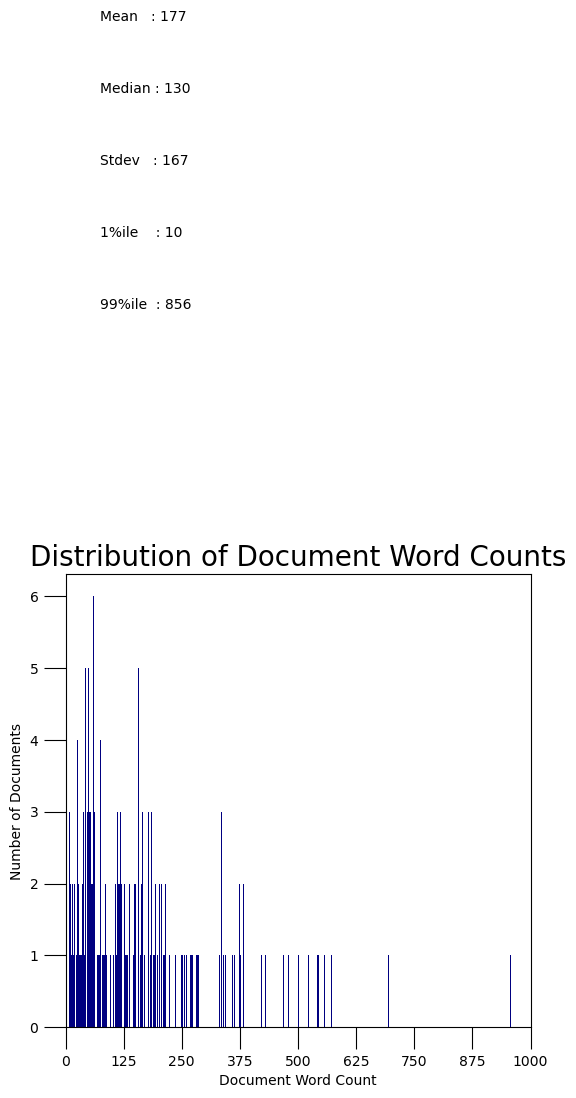

In [30]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(6,6), dpi=100)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(75, 14,"Mean   : " + str(round(np.mean(doc_lens))))
plt.text(75, 13, "Median : " + str(round(np.median(doc_lens))))
plt.text(75, 12, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(75, 11, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(75, 10, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=20))
plt.show()

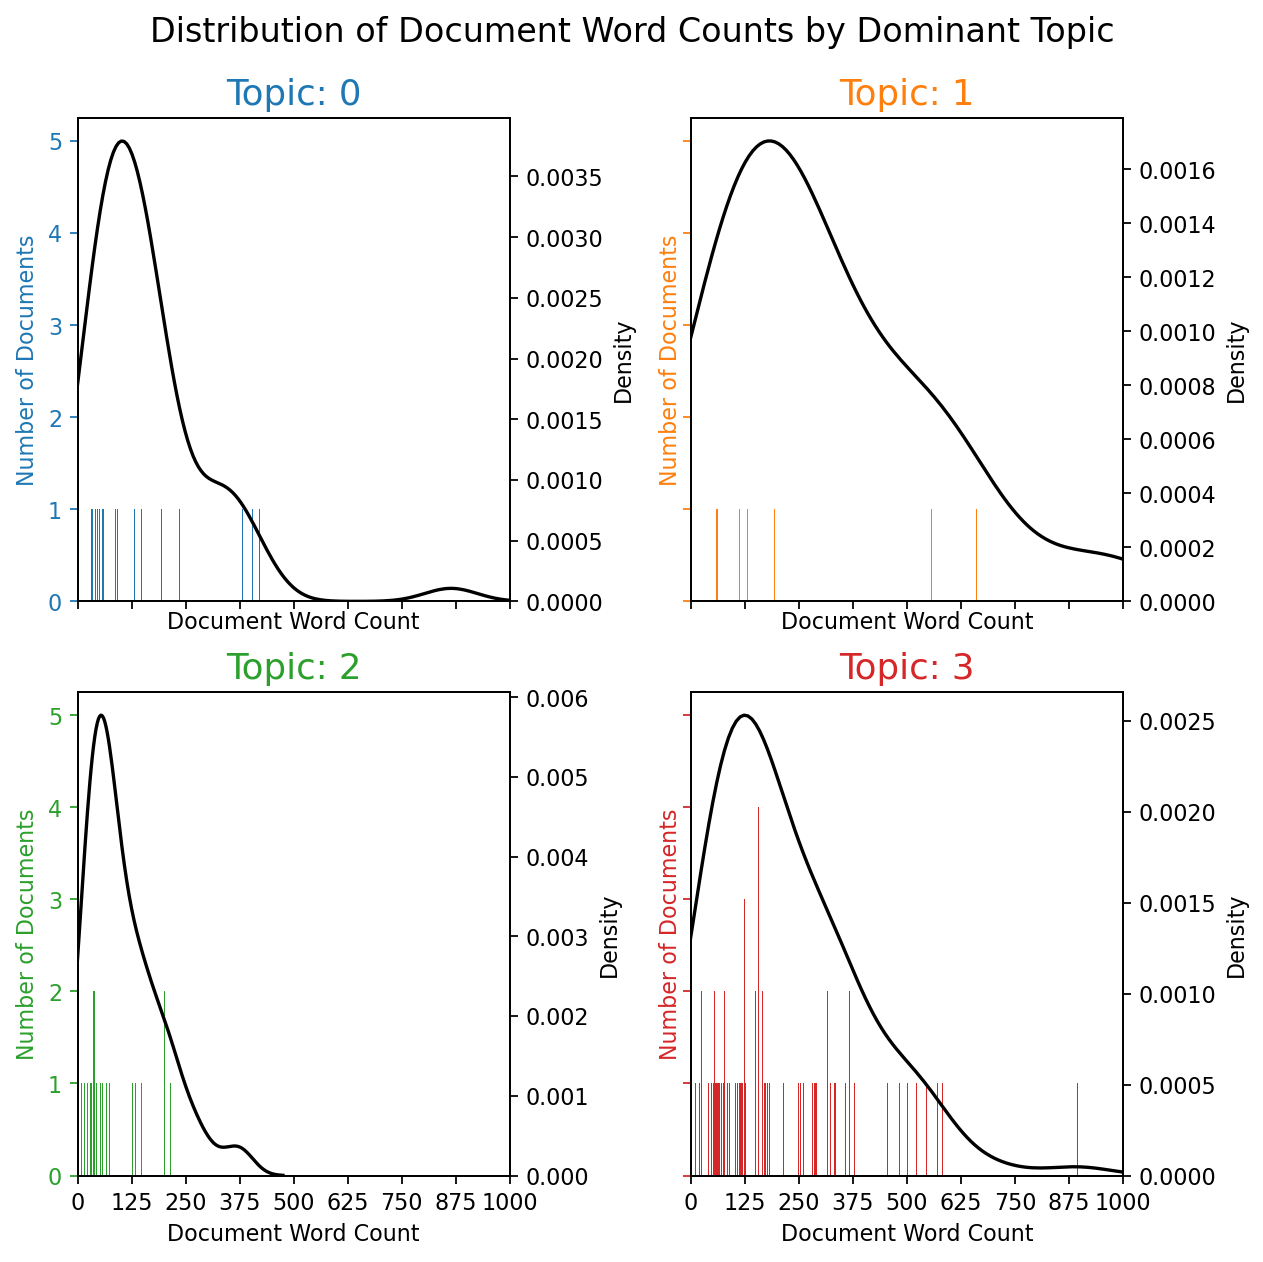

In [31]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,2,figsize=(8,8), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=15)
plt.show()

# 9. Word Clouds of Top N Keywords in Each Topic

Though you’ve already seen what are the topic keywords in each topic, a word cloud with the size of the words proportional to the weight is a pleasant sight. The coloring of the topics I’ve taken here is followed in the subsequent plots as well.

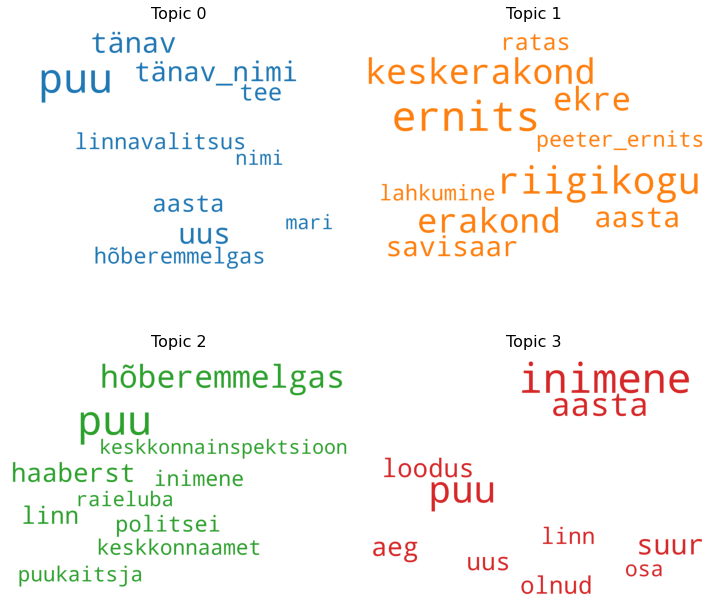

In [32]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = ldamodel2b.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

# 10. Word Counts of Topic Keywords

When it comes to the keywords in the topics, the importance (weights) of the keywords matters. Along with that, how frequently the words have appeared in the documents is also interesting to look.

Let’s plot the word counts and the weights of each keyword in the same chart.
You want to keep an eye out on the words that occur in multiple topics and the ones whose relative frequency is more than the weight. Often such words turn out to be less important. The chart I’ve drawn below is a result of adding several such words to the stop words list in the beginning and re-running the training process.

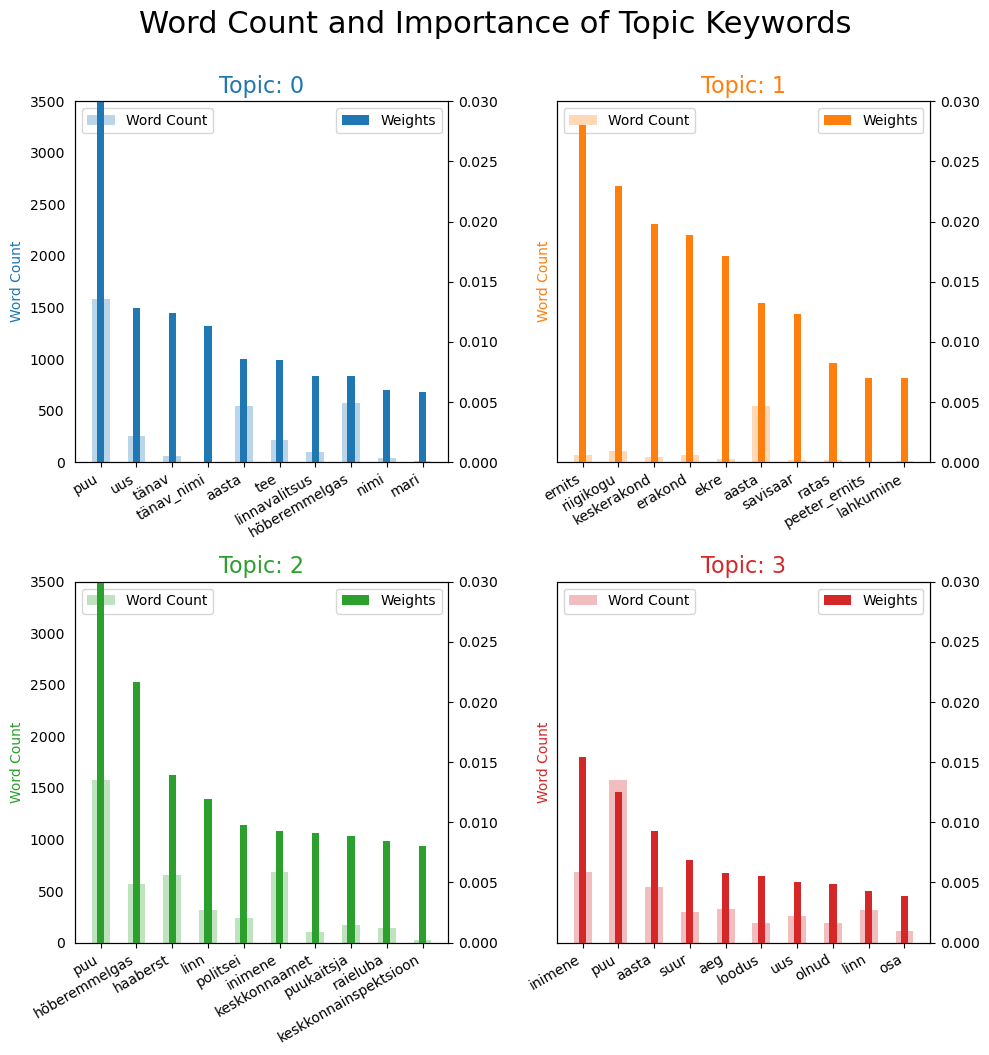

In [33]:
from collections import Counter
topics = ldamodel2b.show_topics(formatted=False)
data_flat = [w for w_list in data_lemmad for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(10,10), sharey=True, dpi=100)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()